In [2]:
import sys
from pathlib import Path
import os
import warnings
import time
import re
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
ANAYLSIS_OUTPUT_ROOTDIR = os.getenv("ANALYSIS_OUTPUT_ROOTDIR")
DATA_ROOTDIR = os.getenv("DATA_ROOTDIR")
sys.path.append(SPIKECOUNTER_PATH)

import numpy as np
import skimage.io as skio
import matplotlib as mpl
import matplotlib.pyplot as plt
from tifffile import imsave
from matplotlib import patches, colors
import os
from scipy import interpolate, optimize, ndimage, stats, signal
from skimage import filters, transform, morphology, exposure, measure
import colorcet as cc
from cycler import cycler
from scipy.io import loadmat
import mat73
from sklearn.utils.extmath import randomized_svd
import pandas as pd
import importlib
from statannotations.Annotator import Annotator

from spikecounter.analysis import traces, images
from spikecounter.ui import visualize
from spikecounter import utils

warnings.filterwarnings("once")
plt.style.use(
    os.path.join(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
)


In [87]:
expt_name = "20220418_DRBJ009_cacna1cMO_hcn4MO_excitability"
rootdir = Path(DATA_ROOTDIR, expt_name)
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure4/", expt_name)
um_per_px = 0.265*4
subfolder = "corrected"
os.makedirs(os.path.join(rootdir, "analysis"), exist_ok=True)
os.makedirs(output_datadir, exist_ok=True)

### Load metadata and video

In [7]:
snap_metadata = pd.read_csv(rootdir/"Snaps/analysis/experiment_data.csv")

In [27]:
snap_metadata = utils.process_experiment_metadata(snap_metadata, regexp_dict={
                                                "embryo": r"(?<=_)\w\d+(?=_)",
                                                "mo":r"(?<=\d)[A-Za-z]+[A-Za-z0-9]+(?=MO)"})
snap_metadata = snap_metadata[snap_metadata["embryo"] != "None"]

In [28]:
snap_metadata["embryo"] = snap_metadata["mo"] + "_" + snap_metadata["embryo"]

In [48]:
expt_info = utils.process_experiment_metadata(pd.read_csv(Path(rootdir,"analysis", subfolder, "experiment_data.csv")),
                                             regexp_dict={"embryo": r"(?<=_)\w\d+(?=_)",
                                                "mo":r"(?<=\d)[A-Za-z]+[A-Za-z0-9]+(?=MO)"})
expt_info = expt_info.iloc[4:]
expt_info["embryo"] = expt_info["mo"] + "_" + expt_info["embryo"]
expt_info = expt_info.reset_index()
del expt_info["index"]

In [49]:
expt_info

,start_time,file_name,offset,embryo,mo
0,11:27:41,112741hcn4MO_E6_stim,1885,hcn4_E6,hcn4
1,11:36:40,113640hcn4MO_E6_stim,2424,hcn4_E6,hcn4
2,11:39:25,113925hcn4MO_E6_stim_fast,2589,hcn4_E6,hcn4
3,11:40:22,114022hcn4MO_E6_stim_fast_target,2646,hcn4_E6,hcn4
4,11:42:21,114221hcn4MO_E7_stim,2765,hcn4_E7,hcn4
5,11:44:50,114450hcn4MO_E8_stim,2914,hcn4_E8,hcn4
6,11:46:47,114647hcn4MO_E10_stim,3031,hcn4_E10,hcn4
7,11:52:56,115256hcn4MO_E10_stim_target2,3400,hcn4_E10,hcn4
8,11:53:55,115355hcn4MO_E10_stim_target,3459,hcn4_E10,hcn4
9,11:58:55,115855cavMO_E1_stim,3759,cav_E1,cav


In [52]:
utils.reload_libraries(utils)

/n/home11/bjia/SpikeCounter/spikecounter/utils.py:265: DeprecationWarning: invalid escape sequence \d
  re.search("\d+", f.readline()).group(0)


In [66]:
matched_expt_info = utils.match_experiments_to_snaps(expt_info, snap_metadata)
matched_expt_info = matched_expt_info[~matched_expt_info["snap_file"].isna()]

In [68]:
expts_by_embryo = matched_expt_info.set_index("mo")

In [86]:
mo="cav"
expt_idx = -1
filename = expts_by_embryo.loc[mo].iloc[expt_idx]["file_name"]
img, expt_data = images.load_image(rootdir, filename, subfolder="corrected")
traces_dict, t = utils.traces_to_dict(expt_data)
dt = np.mean(np.diff(t))
t = t[:img.shape[0]]
print(dt)

[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20220418_DRBJ009_cacna1cMO_hcn4MO_excitability/corrected/124328cavMO_E17_stim/Sq_camera.bin'
0.10263


### Get biological landmark

In [87]:
nkx_path = expts_by_embryo.loc[mo].iloc[expt_idx]["snap_file"]
nkx = skio.imread(os.path.join(rootdir, "Snaps", nkx_path))
factor = 4
nkx_downsample = transform.downscale_local_mean(nkx, (factor,factor))


In [88]:
img.shape

(291, 216, 216)

In [89]:
offset = [(nkx_downsample.shape[0]-img.shape[1])//2, (nkx_downsample.shape[1]-img.shape[2])//2]
if offset[0] > 0:
    nkx_downsample = nkx_downsample[offset[0]:-offset[0],offset[1]:-offset[1]]

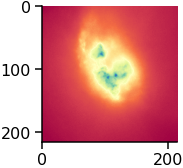

In [90]:
plt.imshow(nkx_downsample)

In [91]:
mean_intensity = img.mean(axis=0)

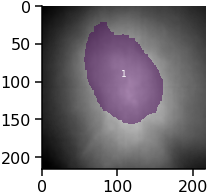

In [92]:
img_mask = nkx_downsample > np.percentile(nkx_downsample, 80)
img_mask = morphology.binary_closing(img_mask, footprint = np.ones((10,10)))

fig1, ax1 = plt.subplots(figsize=(3,3))
q = visualize.display_roi_overlay(mean_intensity, img_mask.astype(int), ax=ax1)

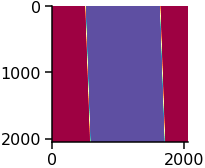

In [93]:
plt.imshow(expt_data["dmd_lightcrafter"]['target_image_space'])

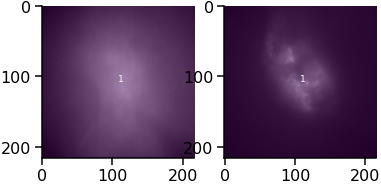

In [94]:
factor = 4
fig1, axes = plt.subplots(1,2, figsize=(6,3))
target_img_space = expt_data["dmd_lightcrafter"]['target_image_space']
# plt.imshow(target_img_space)
target_img_space = target_img_space[::factor,::factor]
offset = [(target_img_space.shape[0]-img.shape[1])//2, (target_img_space.shape[1]-img.shape[2])//2]
target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]
target_img_space = target_img_space.astype(bool)
q = visualize.display_roi_overlay(mean_intensity, target_img_space.astype(int), ax=axes[0])
q2 = visualize.display_roi_overlay(nkx_downsample, target_img_space.astype(int), ax=axes[1])

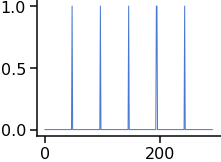

In [95]:
plt.plot(traces_dict["enable488"])

[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20220418_DRBJ009_cacna1cMO_hcn4MO_excitability/stim_frames_removed/124328cavMO_E17_stim/Sq_camera.bin'
[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20220418_DRBJ009_cacna1cMO_hcn4MO_excitability/corrected/124328cavMO_E17_stim/Sq_camera.bin'


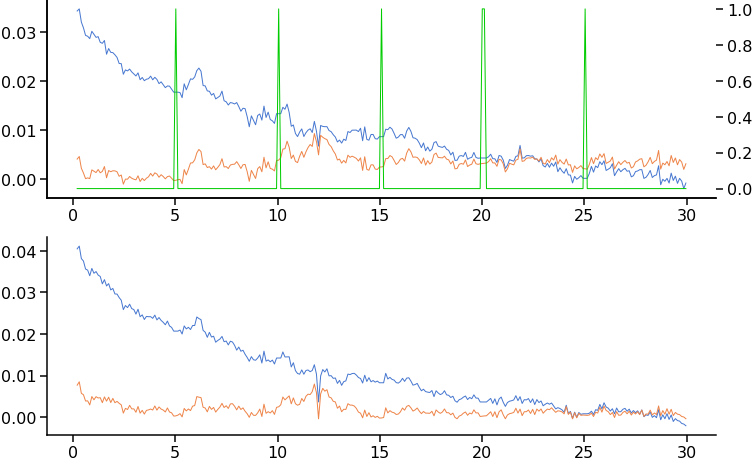

In [96]:
processes = ["stim_frames_removed", "corrected"]
fig1, axes = plt.subplots(2,1,figsize=(12,8))
for p in processes:
    img, expt_data = images.load_image(rootdir, filename, subfolder=p)
    trace_full = images.extract_mask_trace(img, mask=img_mask)
    trace_target = images.extract_mask_trace(img, mask=target_img_space)
    dff_full = traces.intensity_to_dff(trace_full)
    dff_target = traces.intensity_to_dff(trace_target)
    axes[0].plot(t,dff_full)
    axes[1].plot(t,dff_target)
# axes[0].set_ylim(0, 0.01)
# axes[1].set_ylim(0, 0.01)
ax3 = axes[0].twinx()
ax3.plot(t,traces_dict["enable488"][:len(t)], color="C2")

Plot example traces

[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20220418_DRBJ009_cacna1cMO_hcn4MO_excitability/corrected/124328cavMO_E17_stim/Sq_camera.bin'


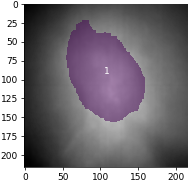

In [146]:
mo="cav"
expt_idx = -1
filename = expts_by_embryo.loc[mo].iloc[expt_idx]["file_name"]
img, expt_data = images.load_image(rootdir, filename, subfolder="corrected")
traces_dict, t = utils.traces_to_dict(expt_data)
dt = np.mean(np.diff(t))
t = t[:img.shape[0]]

nkx_path = expts_by_embryo.loc[mo].iloc[expt_idx]["snap_file"]
nkx = skio.imread(os.path.join(rootdir, "Snaps", nkx_path))
factor = 4
nkx_downsample = transform.downscale_local_mean(nkx, (factor,factor))

offset = [(nkx_downsample.shape[0]-img.shape[1])//2, (nkx_downsample.shape[1]-img.shape[2])//2]
if offset[0] > 0:
    nkx_downsample = nkx_downsample[offset[0]:-offset[0],offset[1]:-offset[1]]

mean_intensity = img.mean(axis=0)
img_mask = nkx_downsample > np.percentile(nkx_downsample, 80)
img_mask = morphology.binary_closing(img_mask, footprint = np.ones((10,10)))

fig1, ax1 = plt.subplots(figsize=(3,3))
q = visualize.display_roi_overlay(mean_intensity, img_mask.astype(int), ax=ax1)

In [147]:
dFF_img = images.get_image_dFF(img)-1
dFF_trace = images.extract_mask_trace(dFF_img, mask=img_mask)

In [148]:
rising_edges = np.argwhere(np.diff(traces_dict["enable488"]) > 0)
falling_edges = np.argwhere(np.diff(traces_dict["enable488"]) < 0)
t_stim = t[rising_edges]
stim_widths = t[falling_edges] - t[rising_edges]
stim_width = 0.02

In [149]:
reload_libraries()

In [150]:
plt.style.use("/n/home11/bjia/bio_publications.mplstyle")

/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


$1\%$
$\Delta F/F$


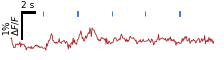

In [152]:
fig1, ax1 = plt.subplots(figsize=(4, 1))
ax1.set_ylim(0.01, 0.035)
ax1.plot(t, dFF_trace, color="#A91F23")

visualize.add_stims(ax1, t_stim, 0.03, 0.04, 0.002)

ylim = ax1.get_ylim()
xlim = ax1.get_xlim()
scalebar_params = {
    "corner_x": xlim[0]+3,
    "corner_y": ylim[1]*0.9,
    "ampl_scale": (ylim[1]-ylim[0])*0.5,
    "time_scale": 2,
    "fontsize": 9,
    "thickness": (ylim[1]-ylim[0])*0.02,
    "xlabel_offset_y": (ylim[1]-ylim[0])*0.1,
    "xlabel_offset_x": 0,
    "ylabel_offset_x": -3,
    "ylabel_offset_y": 0.003,
    "ylabel": r"$%d\%%$" "\n" r"$\Delta F/F$"
}
visualize.plot_scalebars(ax1, scalebar_params, pct_f=True)
plt.savefig(os.path.join(figdir, "Supplementary Figures", "cavMO", "BU_cacna1cMO_pacing_trace.svg"))

[Errno 2] No such file or directory: '/n/holyscratch01/cohen_lab/bjia/20220418_DRBJ009_cacna1cMO_hcn4MO_excitability/corrected/120939tnnt2aMO_E1_stim/Sq_camera.bin'


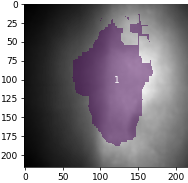

In [123]:
mo="tnnt2a"
expt_idx = 0
filename = expts_by_embryo.loc[mo].iloc[expt_idx]["file_name"]
img, expt_data = images.load_image(rootdir, filename, subfolder="corrected")
traces_dict, t = utils.traces_to_dict(expt_data)
dt = np.mean(np.diff(t))
t = t[:img.shape[0]]

nkx_path = expts_by_embryo.loc[mo].iloc[expt_idx]["snap_file"]
nkx = skio.imread(os.path.join(rootdir, "Snaps", nkx_path))
factor = 4
nkx_downsample = transform.downscale_local_mean(nkx, (factor,factor))

offset = [(nkx_downsample.shape[0]-img.shape[1])//2, (nkx_downsample.shape[1]-img.shape[2])//2]
if offset[0] > 0:
    nkx_downsample = nkx_downsample[offset[0]:-offset[0],offset[1]:-offset[1]]

mean_intensity = img.mean(axis=0)
img_mask = nkx_downsample > np.percentile(nkx_downsample, 80)
img_mask = morphology.binary_closing(img_mask, footprint = np.ones((10,10)))

fig1, ax1 = plt.subplots(figsize=(3,3))
q = visualize.display_roi_overlay(mean_intensity, img_mask.astype(int), ax=ax1)

In [124]:
dFF_img = images.get_image_dFF(img)-1
dFF_trace = images.extract_mask_trace(dFF_img, mask=img_mask)

In [125]:
rising_edges = np.argwhere(np.diff(traces_dict["enable488"]) > 0)
falling_edges = np.argwhere(np.diff(traces_dict["enable488"]) < 0)
t_stim = t[rising_edges]
stim_widths = t[falling_edges] - t[rising_edges]
stim_width = 0.02

/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


$1\%$
$\Delta F/F$


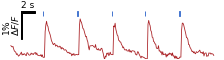

In [145]:
fig1, ax1 = plt.subplots(figsize=(4, 1))
ax1.plot(t, dFF_trace, color="#A91F23")
ax1.set_ylim(0.01, 0.035)

visualize.add_stims(ax1, t_stim, 0.03, 0.04, 0.002)

ylim = ax1.get_ylim()
xlim = ax1.get_xlim()
scalebar_params = {
    "corner_x": xlim[0]+3,
    "corner_y": ylim[1]*0.9,
    "ampl_scale": (ylim[1]-ylim[0])*0.5,
    "time_scale": 2,
    "fontsize": 9,
    "thickness": (ylim[1]-ylim[0])*0.02,
    "xlabel_offset_y": (ylim[1]-ylim[0])*0.1,
    "xlabel_offset_x": 0,
    "ylabel_offset_x": -3,
    "ylabel_offset_y": 0.003,
    "ylabel": r"$%d\%%$" "\n" r"$\Delta F/F$"
}
visualize.plot_scalebars(ax1, scalebar_params, pct_f=True)
plt.savefig(os.path.join(figdir, "Supplementary Figures", "cavMO", "BU_tnnt2aMO_pacing_trace.svg"))

Get spike-triggered averages

In [69]:
comp_data = expts_by_embryo.loc[["tnnt2a", "cav"]]


In [70]:
stas = {}

/tmp/ipykernel_232748/3194633243.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(figsize=(3,3))


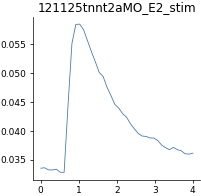

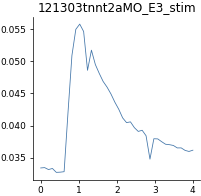

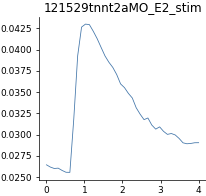

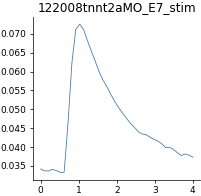

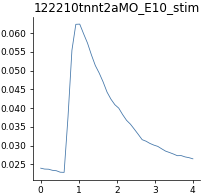

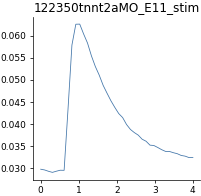

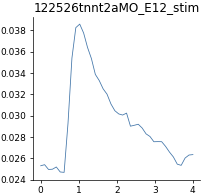

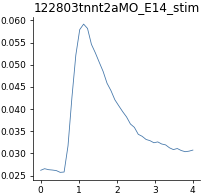

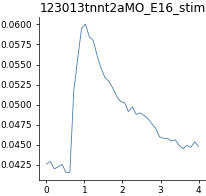

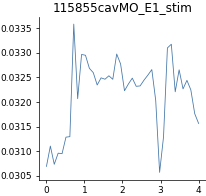

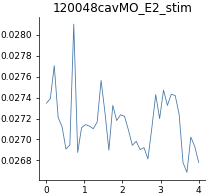

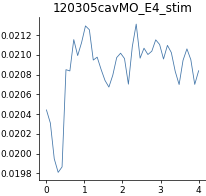

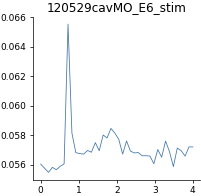

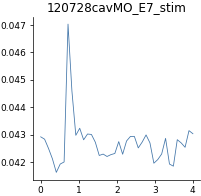

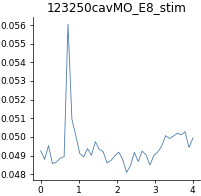

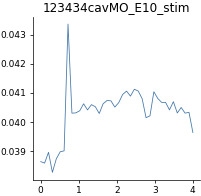

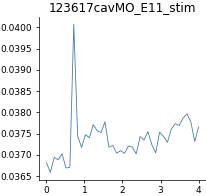

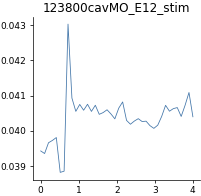

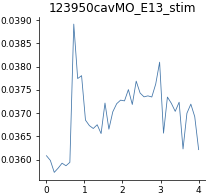

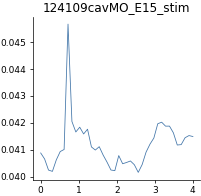

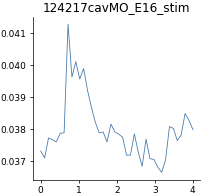

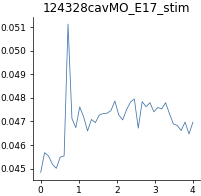

In [72]:
plt.close("all")
sta_before_s = 0.5
sta_after_s = 3.5
for i in range(comp_data.shape[0]):
    filename = comp_data.iloc[i]["file_name"]
    img, expt_data = images.load_image(rootdir, filename, subfolder="corrected")
    traces_dict, t = utils.traces_to_dict(expt_data)
    dt = np.mean(np.diff(t))
    t = t[:img.shape[0]]
    dt = np.mean(np.diff(t))
    sta_bounds = (int(np.ceil(sta_before_s/dt)),int(np.ceil(sta_after_s/dt)))

    nkx_path = comp_data["snap_file"].iloc[i]
    nkx = skio.imread(os.path.join(rootdir, "Snaps", nkx_path))
    factor = 4
    nkx_downsample = transform.downscale_local_mean(nkx, (factor,factor))

    offset = [(nkx_downsample.shape[0]-img.shape[1])//2, (nkx_downsample.shape[1]-img.shape[2])//2]
    if offset[0] > 0:
        nkx_downsample = nkx_downsample[offset[0]:-offset[0],offset[1]:-offset[1]]

    mean_intensity = img.mean(axis=0)
    img_mask = nkx_downsample > np.percentile(nkx_downsample, 80)
    img_mask = morphology.binary_closing(img_mask, footprint = np.ones((10,10)))
    
    dFF_img = images.get_image_dFF(img)-1
    
    rising_edges = np.argwhere(np.diff(traces_dict["enable488"]) > 0)
    sta_img, _ = images.spike_triggered_average_video(dFF_img, rising_edges, sta_bounds, normalize_height=False)
    sta_trace = images.extract_mask_trace(sta_img, mask=img_mask)
    stas[filename] = sta_trace
    fig1, ax1 = plt.subplots(figsize=(3,3))
    ax1.set_title(filename)
    ax1.plot(np.arange(len(sta_trace))*dt, sta_trace)

In [73]:
stas_tnnt2a = []
stas_cacna1c = []

control = comp_data.loc["tnnt2a"]
for i in range(control.shape[0]):
    stas_tnnt2a.append(stas[control.iloc[i]["file_name"]])

cav = comp_data.loc["cav"]
for i in range(cav.shape[0]):
    stas_cacna1c.append(stas[cav.iloc[i]["file_name"]])

In [74]:
tnnt2a = np.array(stas_tnnt2a)
cacna1c = np.array(stas_cacna1c)

In [75]:
tnnt2a -= np.min(tnnt2a, axis=1)[:,None]
cacna1c -= np.min(cacna1c, axis=1)[:,None]

In [76]:
mean_tnnt2a = np.mean(tnnt2a, axis=0)
std_tnnt2a = np.std(tnnt2a, axis=0)
mean_cacna1c = np.mean(cacna1c, axis=0)
std_cacna1c = np.std(cacna1c, axis=0)

In [ ]:
ticks = (np.arange(len(mean_tnnt2a))-int(np.ceil(sta_before_s/dt)))*dt

In [88]:
cacna1c_df = pd.DataFrame(cacna1c.T, columns = [f"embryo_{i}" for i in range(cacna1c.shape[0])])
cacna1c_df["time_s"] = ticks

tnnt2a_df = pd.DataFrame(tnnt2a.T, columns = [f"embryo_{i}" for i in range(tnnt2a.shape[0])])
tnnt2a_df["time_s"] = ticks

cacna1c_df.to_csv(output_datadir/"cacna1c_sta.csv")
tnnt2a_df.to_csv(output_datadir/"tnnt2a_sta.csv")

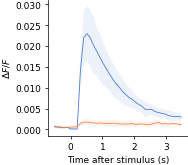

In [182]:
fig1, ax1 = plt.subplots(figsize=(2.5,2.5))
ticks = (np.arange(len(mean_tnnt2a))-int(np.ceil(sta_before_s/dt)))*dt
ax1.plot(ticks, mean_tnnt2a)
ax1.fill_between(ticks, mean_tnnt2a-std_tnnt2a, mean_tnnt2a+std_tnnt2a, alpha=0.1)
ax1.plot(ticks, mean_cacna1c)
ax1.fill_between(ticks, mean_cacna1c-std_cacna1c, mean_cacna1c+std_cacna1c, alpha=0.1)
ax1.set_xlabel("Time after stimulus (s)")
ax1.set_ylabel(r"$\Delta F/F$")
plt.savefig(output_datadir/"sta_comparison.svg")